In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import collections
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier # 앙상블 

from sklearn.metrics import confusion_matrix, classification_report # 정오분류표
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score,classification_report,confusion_matrix  # ROC곡선 그리기
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.model_selection import learning_curve, validation_curve # 학습곡선, 검증곡선
from sklearn.model_selection import GridSearchCV, cross_val_score  # 하이퍼파라미터 튜닝, 교차타당도

from sklearn.tree import DecisionTreeClassifier # 결정 트리
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier # 앙상블 


# 데이터 읽기

In [33]:
origin_df = pd.read_csv("data/newquant_naver_kospi_data.csv",index_col=['Date'],parse_dates=True)

In [34]:
origin_df.head()

Open         High          Low        Close    Adj Close  \
Date                                                                          
2005-01-04  7068.327148  7109.184570  6913.069336  7027.469727  6893.216309   
2005-01-05  6913.069336  6978.440918  6815.011230  6945.754883  6813.062500   
2005-01-06  6978.440918  7305.299805  6847.697266  6986.612305  6853.140137   
2005-01-07  7043.812500  7231.756836  7019.298340  7223.585449  7085.585449   
2005-01-10  7313.471680  7599.473145  7313.471680  7395.186035  7253.907715   

             Volume       S&P500         SOX    VIX       KOSPI  ...  WPR60  \
Date                                                             ...          
2005-01-04  2256630  1188.050049  410.359985  13.98  886.900024  ...    NaN   
2005-01-05  1773241  1183.739990  404.250000  14.09  885.190002  ...    NaN   
2005-01-06  7480900  1187.890015  402.140015  13.58  871.280029  ...    NaN   
2005-01-07  4612385  1186.189941  407.559998  13.49  870.840027  ...    NaN   
2005-01-10  4720077  1190.250000  406.250000  13.23  874.179993  ...    NaN   

            WPR90  ADX14  ADX30  ADX60  ADX90  ADXR14  ADXR30  ADXR60  ADXR90  
Date                                                                           
2005-01-04    NaN    NaN    NaN    NaN    NaN     NaN     NaN     NaN     NaN  
2005-01-05    NaN    NaN    NaN    NaN    NaN     NaN     NaN     NaN     NaN  
2005-01-06    NaN    NaN    NaN    NaN    NaN     NaN     NaN     NaN     NaN  
2005-01-07    NaN    NaN    NaN    NaN    NaN     NaN     NaN     NaN     NaN  
2005-01-10    NaN    NaN    NaN    NaN    NaN     NaN     NaN     NaN     NaN  

[5 rows x 58 columns]

* shift -n이면 해당일 제외 , shift -n-1이면 해당일 포함한 평균이다.

다음날로부터 N일후 평균가격이 avg_pricen으로 들어가있는 것을 확인할 수 있다.

In [35]:
n_list = [1,3,5,7,10,20,30,60,90]
for n in n_list:
    col_name = 'avg_price'+str(n)

    origin_df[col_name] = origin_df['Close'].rolling(window=n).mean()
    origin_df[col_name] = origin_df[col_name].shift(-n)
    # shift -n이면 해당일 제외 , shift -n-1이면 해당일 포함한 평균이다.
    diffs = origin_df[col_name]-origin_df['Close']
    label_name = 'label'+str(n)
    origin_df[label_name] = np.where(diffs>0,1,0)

In [36]:
origin_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4127 entries, 2005-01-04 to 2021-09-17
Data columns (total 76 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          4127 non-null   float64
 1   High          4127 non-null   float64
 2   Low           4127 non-null   float64
 3   Close         4127 non-null   float64
 4   Adj Close     4127 non-null   float64
 5   Volume        4127 non-null   int64  
 6   S&P500        4002 non-null   float64
 7   SOX           4001 non-null   float64
 8   VIX           4002 non-null   float64
 9   KOSPI         4106 non-null   float64
 10  kosATR14      4106 non-null   float64
 11  kosATR30      4106 non-null   float64
 12  kosATR60      4106 non-null   float64
 13  kosATR90      4106 non-null   float64
 14  kosADX14      4106 non-null   float64
 15  kosADX30      4106 non-null   float64
 16  kosADX60      4106 non-null   float64
 17  kosADX90      4106 non-null   float64
 18  log_return

In [37]:
origin_df.describe()

Open           High            Low          Close  \
count    4127.000000    4127.000000    4127.000000    4127.000000   
mean   107285.716706  108867.769503  105638.859967  107228.054337   
std     88477.858209   89658.209714   87237.917537   88404.162736   
min      6692.439453    6888.554688    6635.238770    6635.238770   
25%     44493.691406   45229.121094   43635.683594   44371.117188   
50%     68395.257812   69866.125000   67292.109375   68027.539062   
75%    151600.000000  153800.000000  149800.000000  151550.000000   
max    460000.000000  465000.000000  452000.000000  454000.000000   

           Adj Close        Volume       S&P500          SOX          VIX  \
count    4127.000000  4.127000e+03  4002.000000  4001.000000  4002.000000   
mean   106358.600620  9.240255e+05  1906.827903   826.803146    19.174950   
std     88437.087005  7.075877e+05   830.455246   701.711500     9.372813   
min      6508.479492  0.000000e+00   676.530029   171.320007     9.140000   
25%     43523.449219  4.784515e+05  1270.912537   398.940002    13.120000   
50%     67045.445312  7.339820e+05  1559.344971   500.980011    16.350000   
75%    150177.640625  1.128498e+06  2430.047546  1080.500000    22.177500   
max    454000.000000  1.010686e+07  4536.950195  3473.600098    82.690002   

             KOSPI  ...    avg_price10      label10    avg_price20  \
count  4106.000000  ...    4117.000000  4127.000000    4107.000000   
mean   1909.019668  ...  107036.744595     0.546886  106766.095722   
std     454.601921  ...   87810.938639     0.497857   87061.617187   
min     870.840027  ...    6949.023584     0.000000    7114.904565   
25%    1658.869965  ...   44653.033594     0.000000   44530.461426   
50%    1960.380005  ...   68297.200000     1.000000   67696.597070   
75%    2089.264954  ...  152000.000000     1.000000  151905.000000   
max    3305.209961  ...  444600.000000     1.000000  441875.000000   

           label20    avg_price30      label30    avg_price60      label60  \
count  4127.000000    4097.000000  4127.000000    4067.000000  4127.000000   
mean      0.582990  106492.360990     0.582505  105645.446722     0.598498   
std       0.493124   86286.121533     0.493206   83777.948981     0.490262   
min       0.000000    7126.344629     0.000000    7240.881494     0.000000   
25%       0.000000   44518.204036     0.000000   44988.880924     0.000000   
50%       1.000000   67288.023047     1.000000   67206.308659     1.000000   
75%       1.000000  152033.333333     1.000000  152983.333333     1.000000   
max       1.000000  439033.333333     1.000000  429833.333333     1.000000   

         avg_price90      label90  
count    4037.000000  4127.000000  
mean   104864.514155     0.621517  
std     81445.142050     0.485068  
min      7394.369059     0.000000  
25%     45125.617057     0.000000  
50%     67170.898872     1.000000  
75%    151888.888889     1.000000  
max    409483.333333     1.000000  

[8 rows x 76 columns]

# 초기 세팅
* 기간 : 2011.01.03~2020.12.31
* train /test 비율 : 8 : 2    -> val 만들 경우: 20% 
* shuffle = True
* random seed = 1234
* 변수 : baseline data 변수 다 사용 ( 추후에 성능이 가장 높은 조합으로 변경해 수정)
* 7일 30일 90일 
* null : df.dropna(inplace=True)
* min-max scaler

## 범위

In [38]:
df = origin_df['2011-01-01':'2020-12-31']

In [39]:
df.isnull().sum()

Open           0
High           0
Low            0
Close          0
Adj Close      0
              ..
label30        0
avg_price60    0
label60        0
avg_price90    0
label90        0
Length: 76, dtype: int64

## 결측치

In [40]:
df.dropna(inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2360 entries, 2011-01-03 to 2020-12-30
Data columns (total 76 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2360 non-null   float64
 1   High          2360 non-null   float64
 2   Low           2360 non-null   float64
 3   Close         2360 non-null   float64
 4   Adj Close     2360 non-null   float64
 5   Volume        2360 non-null   int64  
 6   S&P500        2360 non-null   float64
 7   SOX           2360 non-null   float64
 8   VIX           2360 non-null   float64
 9   KOSPI         2360 non-null   float64
 10  kosATR14      2360 non-null   float64
 11  kosATR30      2360 non-null   float64
 12  kosATR60      2360 non-null   float64
 13  kosATR90      2360 non-null   float64
 14  kosADX14      2360 non-null   float64
 15  kosADX30      2360 non-null   float64
 16  kosADX60      2360 non-null   float64
 17  kosADX90      2360 non-null   float64
 18  log_return

## 라벨링 시각화

In [42]:
ratio_list = []
total = len(df)
for n in n_list : 
    label_name = 'label'+str(n)
    ratio = round(df[label_name].sum() / total * 100)
    ratio_list.append(ratio)

In [43]:
ratio_list

[48, 51, 53, 52, 53, 57, 57, 59, 60]

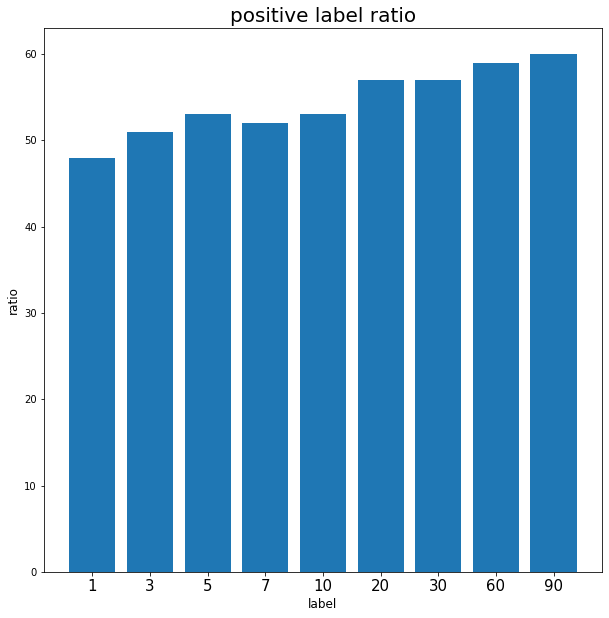

In [44]:
index = np.arange(len(n_list))
plt.bar(index, ratio_list)
plt.title('positive label ratio',fontsize=20)
plt.xlabel('label', fontsize=12)
plt.ylabel('ratio',fontsize=12)
plt.xticks(index,n_list, fontsize=15)
plt.show()

# Prediction

## feature

In [45]:
# 가격데이터
feature1_list = ['Open','High','Low','Volume','Close'] #log_return

# 기술지표 데이터
feature2_list = ['MA5', 'MA10', 'MA20', 'MA60',
       'MA20_ratio', 'MA60_ratio', 'MA20_volume', 'MA60_volumne', 'RASD5',
       'RASD10', 'MACD', 'CCI14', 'CCI30', 'CCI60', 'ATR14', 'ATR30', 'ATR60',
       'ATR90', 'ub', 'middle', 'lb', 'MTM1', 'MTM3', 'MTM6', 'ROC60', 'ROC90',
       'WPR14', 'WPR30', 'WPR60', 'WPR90', 'ADX14', 'ADX30', 'ADX60', 'ADX90',
                'ADXR14', 'ADXR30', 'ADXR60', 'ADXR90']
# 시장지표 데이터
feature3_list = ['S&P500', 'SOX', 'VIX','KOSPI',
    'kosATR14',
       'kosATR30', 'kosATR60', 'kosATR90', 'kosADX14', 'kosADX30', 'kosADX60',
       'kosADX90']
# 라벨링에 사용할 데이터
feature4_list = ['next_price','next_rtn']

# 기술지표 중 가격 정보가 덜 드러나는 데이터 
feature5_list = ['CCI14', 'CCI30', 'CCI60', 'ATR14', 'ATR30', 'ATR60',
       'MTM1', 'MTM3', 'MTM6', 'ROC60', 'ROC90',
       'WPR14', 'WPR30', 'WPR60', 'WPR90', 'ADX14', 'ADX30', 'ADX60', 'ADX90',
                'ADXR14', 'ADXR30', 'ADXR60', 'ADXR90']

# 기술지표 중 가격 정보가 드러나는 데이터
feature6_list = ['MA5', 'MA10', 'MA20', 'MA60',
       'MA20_ratio', 'MA60_ratio', 'MA20_volume', 'MA60_volumne', 'RASD5',
       'RASD10']

all_x_feature = feature1_list+feature2_list+feature3_list

# 초기 실험에 사용했던 피처 
Origin_feature = feature1_list +['S&P500', 'SOX', 'VIX','KOSPI']+ ['MA5', 'MA10', 'MA20', 'MA60',
         'MA20_volume', 'MA60_volumne', 'RASD5',
       'RASD10', 'MACD', 'CCI14', 'ATR14','ub', 'middle', 'lb', 'MTM1', 'MTM3', 'ROC60',
       'WPR14',  'ADX14', 
                'ADXR14']

In [46]:
len(Origin_feature)

29

In [47]:
for r in Origin_feature:
    print(r,end=', ')

Open, High, Low, Volume, Close, S&P500, SOX, VIX, KOSPI, MA5, MA10, MA20, MA60, MA20_volume, MA60_volumne, RASD5, RASD10, MACD, CCI14, ATR14, ub, middle, lb, MTM1, MTM3, ROC60, WPR14, ADX14, ADXR14, 

## RF

In [48]:

X = df[Origin_feature]

# Min Max Scaler를 사용해 스케일링
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

for n in n_list:
    label_name = 'label'+str(n)
    y = df[label_name]

    # train test split
    # label별로 비교하기위해 startify x
    X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size=0.2,stratify=y, random_state=1234)
    print('Lable'+str(n)+' 양성비율','train : %.3f' %(sum(y_train)/len(y_train)),end=' ')
    print('test : %.3f' %(sum(y_test)/len(y_test)),end='\t')


    forest = RandomForestClassifier(criterion='entropy',n_estimators=700,random_state=1)
    forest.fit(X_train,y_train)
    y_pred = forest.predict(X_test)


    print(label_name,'정확도: %.2f' % (accuracy_score(y_test, y_pred)*100))

Lable1 양성비율 train : 0.480 test : 0.479	label1 정확도: 52.75
Lable3 양성비율 train : 0.506 test : 0.506	label3 정확도: 66.31
Lable5 양성비율 train : 0.526 test : 0.525	label5 정확도: 80.72
Lable7 양성비율 train : 0.522 test : 0.523	label7 정확도: 82.20
Lable10 양성비율 train : 0.534 test : 0.534	label10 정확도: 86.86
Lable20 양성비율 train : 0.570 test : 0.570	label20 정확도: 92.80
Lable30 양성비율 train : 0.572 test : 0.572	label30 정확도: 93.43
Lable60 양성비율 train : 0.586 test : 0.587	label60 정확도: 94.70
Lable90 양성비율 train : 0.603 test : 0.604	label90 정확도: 97.03


In [49]:
X.shape

(2360, 29)

# adaboost

In [50]:

X = df[Origin_feature]

# Min Max Scaler를 사용해 스케일링
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

for n in n_list:
    label_name = 'label'+str(n)
    y = df[label_name]

    # train test split
    # label별로 비교하기위해 startify x
    X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size=0.2,stratify=y, random_state=1234)
    print('Lable'+str(n)+' 양성비율','train : %.3f' %(sum(y_train)/len(y_train)),end=' ')
    print('test : %.3f' %(sum(y_test)/len(y_test)),end='\t')

    tree = DecisionTreeClassifier(max_depth=4,criterion='entropy',random_state=1)
    model =  AdaBoostClassifier(base_estimator=tree, 
                                n_estimators=100,
                                learning_rate = 0.01, 
                                random_state=42)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)


    print(label_name,'정확도: %.2f' % (accuracy_score(y_test, y_pred)*100))

Lable1 양성비율 train : 0.480 test : 0.479	label1 정확도: 53.18
Lable3 양성비율 train : 0.506 test : 0.506	label3 정확도: 55.51
Lable5 양성비율 train : 0.526 test : 0.525	label5 정확도: 68.01
Lable7 양성비율 train : 0.522 test : 0.523	label7 정확도: 66.31
Lable10 양성비율 train : 0.534 test : 0.534	label10 정확도: 76.06
Lable20 양성비율 train : 0.570 test : 0.570	label20 정확도: 86.44
Lable30 양성비율 train : 0.572 test : 0.572	label30 정확도: 81.14
Lable60 양성비율 train : 0.586 test : 0.587	label60 정확도: 90.89
Lable90 양성비율 train : 0.603 test : 0.604	label90 정확도: 93.22


# xgboost

In [51]:

X = df[Origin_feature]

# Min Max Scaler를 사용해 스케일링
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

for n in n_list:
    label_name = 'label'+str(n)
    y = df[label_name]

    # train test split
    # label별로 비교하기위해 startify x
    X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size=0.2,stratify=y, random_state=1234)
    print('Lable'+str(n)+' 양성비율','train : %.3f' %(sum(y_train)/len(y_train)),end=' ')
    print('test : %.3f' %(sum(y_test)/len(y_test)),end='\t')


    model = XGBClassifier(feature_names = X.columns.to_list(), random_seed=1234)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)


    print(label_name,'정확도: %.2f' % (accuracy_score(y_test, y_pred)*100))

Lable1 양성비율 train : 0.480 test : 0.479	[14:17:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { feature_names, random_seed } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:17:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


label1 정확도: 55.08
Lable3 양성비율 train : 0.506 test : 0.506	[14:17:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { feature_names, random_seed } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:17:31] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


label3 정확도: 61.65
Lable5 양성비율 train : 0.526 test : 0.525	[14:17:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { feature_names, random_seed } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:17:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


label5 정확도: 77.75
Lable7 양성비율 train : 0.522 test : 0.523	[14:17:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { feature_names, random_seed } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:17:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


label7 정확도: 80.93
Lable10 양성비율 train : 0.534 test : 0.534	[14:17:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { feature_names, random_seed } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:17:32] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


label10 정확도: 86.23
Lable20 양성비율 train : 0.570 test : 0.570	[14:17:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { feature_names, random_seed } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:17:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


label20 정확도: 91.53
Lable30 양성비율 train : 0.572 test : 0.572	[14:17:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { feature_names, random_seed } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:17:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


label30 정확도: 91.95
Lable60 양성비율 train : 0.586 test : 0.587	[14:17:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { feature_names, random_seed } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:17:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


label60 정확도: 94.07
Lable90 양성비율 train : 0.603 test : 0.604	[14:17:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { feature_names, random_seed } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:17:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


label90 정확도: 97.03


# 변수 중요도

In [52]:

X = df[Origin_feature]


# 설명성을 위해 Min Max Scaler를 사용하지 않음
#scaler = MinMaxScaler()
# scaler.fit(X)
#X_scaled = scaler.transform(X)
y = df['label30']

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, test_size=0.2, random_state=1234)

# 30일 기준으로 학습 데이터로 모델을 학습시키기
model = XGBClassifier(feature_names = X.columns.to_list(),random_seed=1234)
model.fit(X_train,y_train)

# 예측하기
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# 평가하기
accuracy = accuracy_score(y_test, predictions)
print('Accuracy : %.2f%%' %(accuracy * 100.0))

[14:17:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { feature_names, random_seed } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:17:33] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


Accuracy : 91.95%


In [53]:
import shap

In [54]:
# JS 시각화 라이브러리 로드하기
shap.initjs()

# SHAP 값으로 모델의 예측을 설명하기
# 설명체는 LightGBM, CATBoost, scikit-learn 모델을 입력받을 수 있다.

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)


In [55]:
# 모델이 학습 데이터를 예측한 결과에 대해 SHAP 분석한 결과를 출력
shap.force_plot(explainer.expected_value, shap_values, X_train)

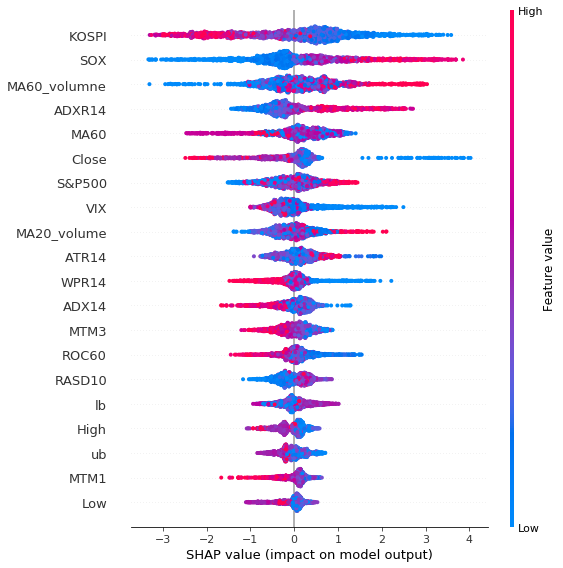

In [56]:
# 모든 피처에 대해 SHAP 값을 계산하고, 영향력을 시각화하는 코드
shap.summary_plot(shap_values, X_train)

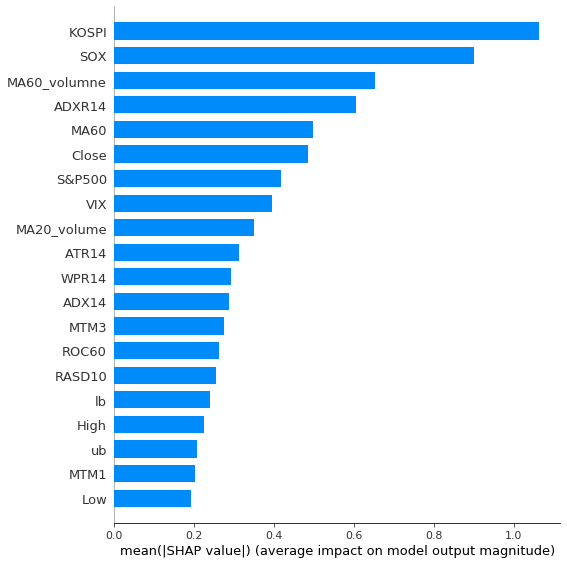

In [57]:
shap.summary_plot(shap_values,X_train, plot_type='bar')

In [58]:
%matplotlib inline
import os

from xgboost import plot_tree

import matplotlib.pyplot as plt

from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 100,300


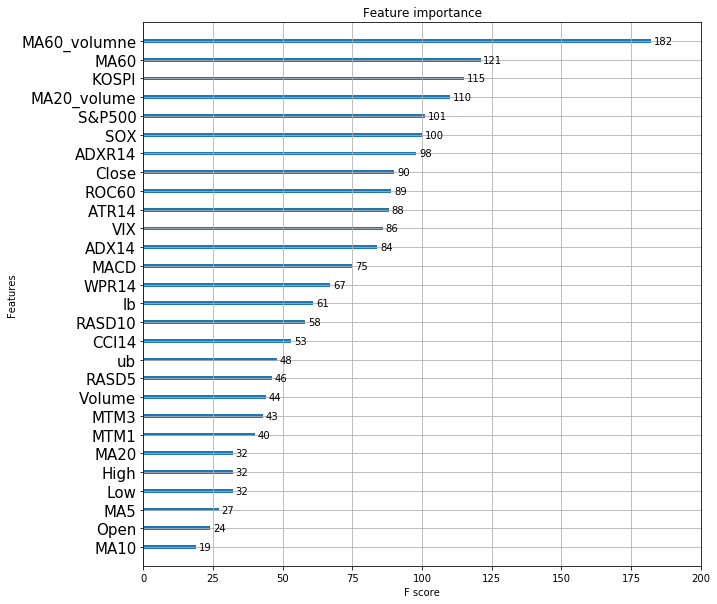

In [59]:
from xgboost import plot_importance

X = df[Origin_feature]

rcParams['figure.figsize'] = 10,10

model.get_booster().feature_names = list(X.columns)
plot_importance(model)

plt.yticks(fontsize = 15)
plt.show()

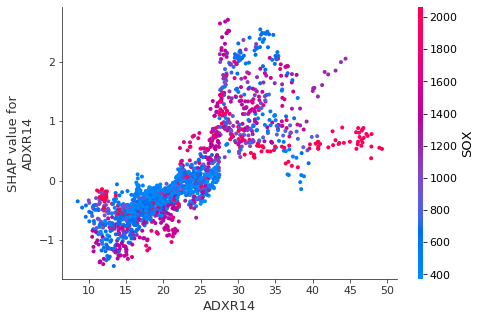

In [60]:
# 하나의 피처가 전체 예측에 미치는 영향력을 SHAP로 계산하고 출력하는 코드
shap.dependence_plot('ADXR14', shap_values, X_train)

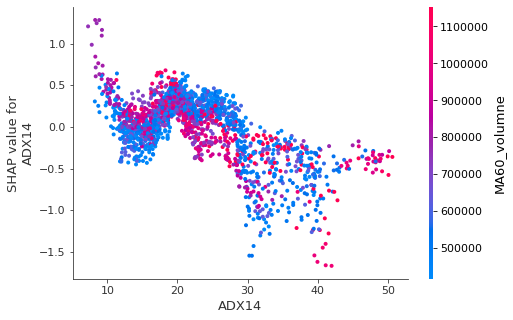

In [61]:
# 하나의 피처가 전체 예측에 미치는 영향력을 SHAP로 계산하고 출력하는 코드
shap.dependence_plot('ADX14', shap_values, X_train)

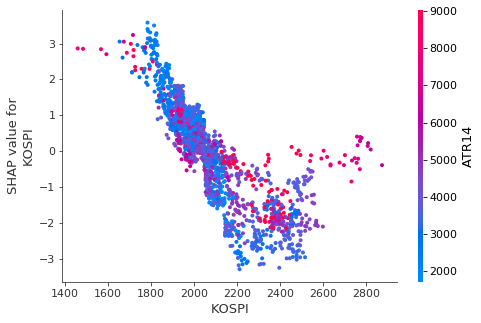

In [62]:
# 하나의 피처가 전체 예측에 미치는 영향력을 SHAP로 계산하고 출력하는 코드
shap.dependence_plot('KOSPI', shap_values, X_train)